Minimal example of Bernoulli used in 1D Gaussian Mixture model, with AutoLowRankMultivariateNormal guide and enumeration used for inference.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.infer import SVI, TraceEnum_ELBO, infer_discrete, config_enumerate
from pyro.infer import Predictive
from pyro.poutine import block
from pyro.infer.autoguide.initialization import init_to_value

Produce some data from two Normal distributions with different means:

In [2]:
def generate_data(n_components = 2, n_observations = 100, ps = 0.9):
    
    mus = torch.tensor((4., 4.))
    b = pyro.sample('b', dist.Bernoulli(probs = ps).expand([n_observations]).to_event(1))
                             
    mean = mus[0] + mus[1]*b
    
    data = pyro.sample("data_target", dist.Normal(loc = mean, scale = 1.))
    
    return data, b

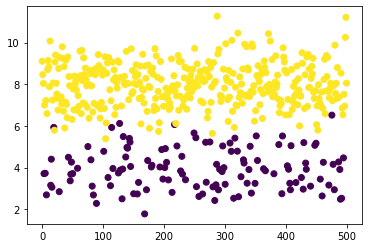

In [3]:
n_components = 2
n_observations = 500
ps = 0.75
data, b = generate_data(n_components, n_observations, ps)
plt.scatter(range(len(data)), data, c = b)

Our model using the Bernoulli distribution to assign observations to components:

In [4]:
@config_enumerate
def model(data, n_components, n_observations, i):
    
    ps = pyro.sample('ps', dist.Dirichlet(torch.ones(n_components)/10.))
    mus = pyro.sample('mus', dist.Gamma(20,2).expand([n_components]).to_event(1))
    with pyro.plate('observations', n_observations):
        b = pyro.sample('b', dist.Bernoulli(probs = ps[0]))                    
        mean = mus[0] + mus[1]*b    
        pyro.sample("data_target", dist.Normal(loc = mean, scale = torch.tensor(1.)), obs = data)

Define custom guide:

In [5]:
# Make appropriate auto guide (and hiding discrete variable)
guide = AutoLowRankMultivariateNormal(poutine.block(model, hide=['b']))

Training:

In [6]:
# Train model:
n_iterations = 20000
optim = pyro.optim.Adam({'lr': 0.001})
elbo = TraceEnum_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
for i in range(n_iterations):
    loss = svi.step(data, n_components, n_observations, i)

posterior = Predictive(model, guide=guide, num_samples=1)(data, n_components, n_observations, i)

In [7]:
# Predict components:
guide_trace = poutine.trace(guide).get_trace(data, n_components, n_observations, i)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals
def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data, n_components, n_observations, i)
    return trace.nodes["b"]["value"]
b_inferred = classifier(data)

Evaluate model:

In [8]:
print('Percentage correctly classified: ', np.array(torch.sum(b - b_inferred  == 0)/len(b)))

Percentage correctly classified:  0.986


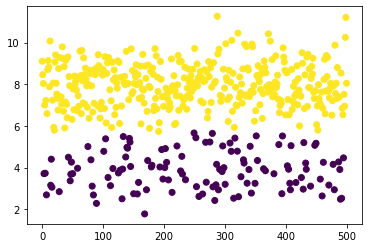

In [10]:
plt.scatter(range(len(data)), data, c = b_inferred)